In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import autograd.numpy as np
from autograd.scipy.misc import logsumexp
import itertools
import time
import corner
import copy

Generate data $\pmb{x}$ for a multivariate normal distribution $\mathcal{N}(\pmb{\beta},\Sigma)$, with covariance matrix $\Sigma = \sigma^2 I_D$

In [2]:
dim = 20
betas = np.linspace(0.5,5.0,num=dim)  # Vector containing the Means of the MVN
sigma = 0.1
cov = np.identity(dim)*(sigma**2)     # Covariance Matrix 

nobj = 500                           # Number of Data Points
L = np.linalg.cholesky(cov)           # Performs a Cholesky decomposition on Covariance Matrix
xis = L @ np.random.randn(dim,nobj)   # Generates random samples Lv, where v ~ N(0,1) 

for i in range(nobj):
    xis[:,i] += betas                 # Generates data x = Lv + beta

Now define functions necessary for the HMC procedure

Note that a multivariate normal distribution with covariance matrix $\Sigma = \sigma^2 I_D$ can be written as the product of univariate normals, i.e.

$$
\frac{1}{\sqrt{(2\pi)^D|\Sigma|}} e^{-\frac{1}{2}(\pmb{x}-\pmb{\mu})^T\Sigma^{-1}(\pmb{x}-\pmb{\mu})} = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-(x_1-\mu_1)^2/(2\sigma^2)} \frac{1}{\sqrt{2\pi\sigma^2}} e^{-(x_2-\mu_2)^2/(2\sigma^2)}\cdot \ ...
$$

This means that the log of this becomes
$$
-\frac{D}{2}\text{log}(2\pi)-D\text{log}(\sigma)-\frac{(x_1-\mu_1)^2}{2\sigma^2}-\frac{(x_2-\mu_2)^2}{2\sigma^2}-...
$$

We will use this fact below to compute the gradient of the logarithm of the target density.

In [3]:
def lngaussian(x, mu, sig):
    """log of a normalized Gaussian"""
    return - 0.5*((x - mu)/sig)**2 - 0.5*np.log(2*np.pi) - np.log(sig)

def gradmulngauss(x,mu,sig):
    """derative wrt mu of the log Gaussian"""
    return (x-mu)/(sig**2)

def gradsigmalngauss(x,mu,sig):
    """derative wrt sigma of the log Gaussian"""
    return ((x - mu)**2)/(sig**3) - (1/sig)

In [4]:
def lnprob(params):
    betas = params[0:dim]
    sigma = params[dim]

    lnlikes = lngaussian(xis,betas.T[:,None],sigma)   # Computes the log likelihood
    res = - np.sum(logsumexp(lnlikes, axis=1))

    if ~np.isfinite(res):
        print("Infinite likelihood call")# with", params)
    return res

def lnprob_grad(params):
    betas = params[0:dim]
    sigma = params[dim]
    
    lnlikes = lngaussian(xis,betas.T[:,None],sigma) # Computes the log likelihood
    lnlikestot = np.sum(lnlikes,axis=0)
    
    grads = gradmulngauss(xis, betas.T[:,None],sigma) # Contains d log(lik)/d mu
    grads2 = gradsigmalngauss(xis, betas.T[:,None],sigma)  # Contains d log(lik)/d sigma
    
    # Code below computes the derivative of logsumexp(log(lik)) wrt mu (subgrads) and sigma (subgrads2)
    esumlnlikes = np.exp(np.sum(lnlikes,axis=0))
    subgrads = -np.dot(grads,esumlnlikes)
    subgrads2 = -np.sum(np.dot(grads2,esumlnlikes))   

    subgrads = np.append(subgrads,subgrads2)

    subgrads = (1/np.sum(np.exp(lnlikestot)))*subgrads
    
    if np.any(~np.isfinite(subgrads)):
        print("Infinite likelihood gradient")# call with", params)
    if np.any(np.isnan(subgrads)):
        print("NaN likelihood gradient")# call with", params)
        
    return subgrads

The code below computes the diagonal of the Hessian

In [5]:
def grad2ndsigmalngauss(x,mu,sig):  
    """2nd derative wrt sigma of the log Gaussian"""
    return -3*((x - mu)**2)/(sig**4) + (1/(sig**2))

def lnprob_hessian(params):
    betas = params[0:dim]
    sigma = params[dim]
    
    lnlikes = lngaussian(xis,betas.T[:,None],sigma)
    lnlikestot = np.sum(lnlikes,axis=0)
    
    grads = gradmulngauss(xis, betas.T[:,None],sigma) # d log(lik)/d mu
    grads2 = gradsigmalngauss(xis, betas.T[:,None],sigma) # d log(lik)/d sigma
    
    gradsmu = np.ones(np.shape(grads))/(sigma**2)  # This is the 2nd derivative of log(lik) wrt mu
    gradssigma = grad2ndsigmalngauss(xis, betas.T[:,None],sigma) # This is the 2nd derivative of log(lik) wrt sigma
    
    # Code below computes the 2nd derivative of logsumexp(log(lik)) wrt mu (grads2ndmu) and sigma (grads2ndsigma)
    esumlnlikes = np.exp(np.sum(lnlikes,axis=0))
    norm = np.sum(np.exp(lnlikestot))
    
    grads2ndmu = -(1/norm)*(np.dot(grads**2,esumlnlikes)-np.dot(gradsmu,esumlnlikes))+(1/(norm**2))*((np.dot(grads,esumlnlikes))**2)
    grads2ndsigma = np.sum(-(1/norm)*(np.dot(grads2**2,esumlnlikes)+np.dot(gradssigma,esumlnlikes)) +(1/(norm**2))*(np.dot(grads2,esumlnlikes)**2))

    diaghessian = np.append(grads2ndmu,grads2ndsigma)

    if np.any(~np.isfinite(diaghessian)):
        print("Infinite hessian") 
    if np.any(np.isnan(diaghessian)):
        print("NaN hessian")
        
    return diaghessian

Now we will define the HMC algorithm

In [6]:
# This function generates one HMC sample with "num_steps" steps of size "step_size" 
# x0 is the initial point, lnprob the posterior distribution, lnprobgrad are gradients.
def hmc_sampler(x0, lnprob, lnprobgrad, step_size,
                num_steps, inv_mass_matrix_diag=None, bounds=None, kwargs={}):

    inv_mass_matrix_diag_sqrt = inv_mass_matrix_diag**0.5
    
    v0 = np.random.randn(x0.size) / inv_mass_matrix_diag_sqrt
    v = v0 - 0.5 * step_size * lnprobgrad(x0, **kwargs)
    
    #Check if got infinite of NaN values for lnprobgrad(x0, **kwargs)
    if(np.any(~np.isfinite(v))):
        return x0
    if(np.any(np.isnan(v))):
        return x0
        
    x = x0 + step_size * v * inv_mass_matrix_diag
    
    # Check if within bounds
    ind_upper = x > bounds[:, 1]
    x[ind_upper] = 2*bounds[ind_upper, 1] - x[ind_upper]
    v[ind_upper] = - v[ind_upper]
    ind_lower = x < bounds[:, 0]
    x[ind_lower] = 2*bounds[ind_lower, 0] - x[ind_lower]
    v[ind_lower] = - v[ind_lower]
    ind_upper = x > bounds[:, 1]
    ind_lower = x < bounds[:, 0]
    ind_bad = np.logical_or(ind_lower, ind_upper)
    if ind_bad.sum() > 0:
        print('Error: could not confine samples within bounds!')
        print('Number of problematic parameters:', ind_bad.sum(), 
              'out of', ind_bad.size)
        return x0
    
    
    for i in range(num_steps):
        v = v - step_size * lnprobgrad(x, **kwargs)
        x = x + step_size * v * inv_mass_matrix_diag
        
        ind_upper = x > bounds[:, 1]
        x[ind_upper] = 2*bounds[ind_upper, 1] - x[ind_upper]
        v[ind_upper] = - v[ind_upper]
        ind_lower = x < bounds[:, 0]
        x[ind_lower] = 2*bounds[ind_lower, 0] - x[ind_lower]
        v[ind_lower] = - v[ind_lower]
        ind_upper = x > bounds[:, 1]
        ind_lower = x < bounds[:, 0]
        ind_bad = np.logical_or(ind_lower, ind_upper)
        if ind_bad.sum() > 0:
            print('Error: could not confine samples within bounds!')
            print('Number of problematic parameters:', ind_bad.sum(), 
                  'out of', ind_bad.size)
            return x0

    v = v - 0.5 * step_size * lnprobgrad(x, **kwargs)
    
    if(np.any(~np.isfinite(v))):
        return x0
    if(np.any(np.isnan(v))):
        return x0
    
    orig = lnprob(x0, **kwargs)
    current = lnprob(x, **kwargs)
    
    orig += 0.5 * np.sum(inv_mass_matrix_diag * v0**2.)
    current += 0.5 * np.sum(inv_mass_matrix_diag * v**2.)
        
    p_accept = min(1.0, np.exp(orig - current))
    if(np.any(~np.isfinite(x))):
        print('Error: some parameters are infinite!', 
              np.sum(~np.isfinite(x)), 'out of', x.size)
        print('HMC steps and stepsize:', num_steps, step_size)
        return x0
    if p_accept > np.random.uniform():
        return x
    else:
        return x0

In [7]:
num_samples, burnin = 200000, 10000

# True Parameters
params = betas
params = np.append(params,sigma)
print("True value of first 6 means", params[0:5])
print("True value of sigma", params[-1])

#Bounds within which we confine our parameter samples
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.0
bounds[:, 1] = np.max(params)+3.0

# Initial Parameter Guesses
param_samples = np.zeros((num_samples, params.size))
param_samples[0, :] = np.random.uniform(0,8,params.size) 

hess = np.abs(lnprob_hessian(param_samples[0, :]))

t1 = time.time() #Will time how long our HMC sampler takes to run
for i in range(1, num_samples):

    if i < 10000:
        num_steps = np.random.randint(10,20) 
        step_size = np.random.uniform(1e-3,2e-2)
    else:
        num_steps = 10
        step_size = np.random.uniform(1e-4,1e-2) #It ran well with (1e-4,1e-2)
        
    if i % 250 == 0:
        if i % 10000 == 0:
            print(i, end=" ")
            
        #Compute updated hessian for the mass matrix
        newparams = np.mean(param_samples[0:i-1, :], axis=0)
        hessold = copy.deepcopy(hess)
        hess = np.abs(lnprob_hessian(newparams))
        if np.any(~np.isfinite(hess)) or np.any(np.isnan(hess)):
            hess = hessold
    
    # Run HMC sampler 
    param_samples[i, :] =\
        hmc_sampler(param_samples[i-1, :],
                    lnprob, lnprob_grad,
                    step_size, num_steps,
                    bounds=bounds, inv_mass_matrix_diag=1/hess)

param_samples = param_samples[burnin:, :]

t2 = time.time()
print("It took ",t2-t1,"seconds")

True value of first 6 means [0.5        0.73684211 0.97368421 1.21052632 1.44736842]
True value of sigma 0.1
10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 It took  803.2378189563751 seconds


Lets see how well our HMC sampler performed

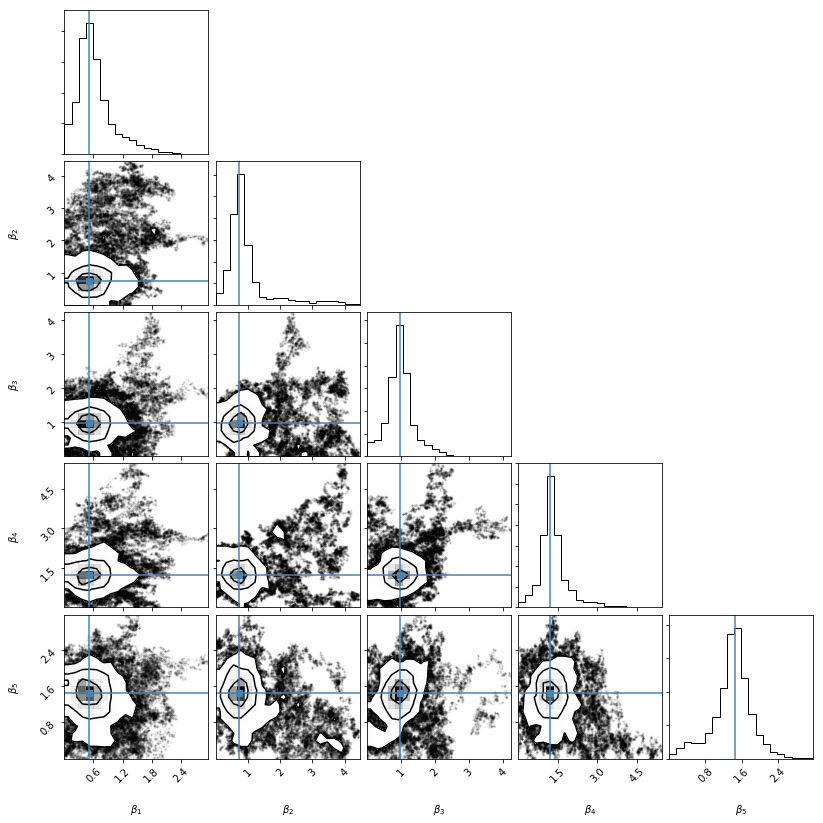

In [10]:
param_names = [r'$\beta_{'+str(i+1)+'}$' for i in range(dim)] +\
   [r'$\sigma$' for i in range(1)]
a = corner.corner(param_samples[:,0:5],color='k',truths=params, labels=param_names)
plt.savefig("HMC_InferredMeans_11Parameters_200000Samples_Burnin10000.png")

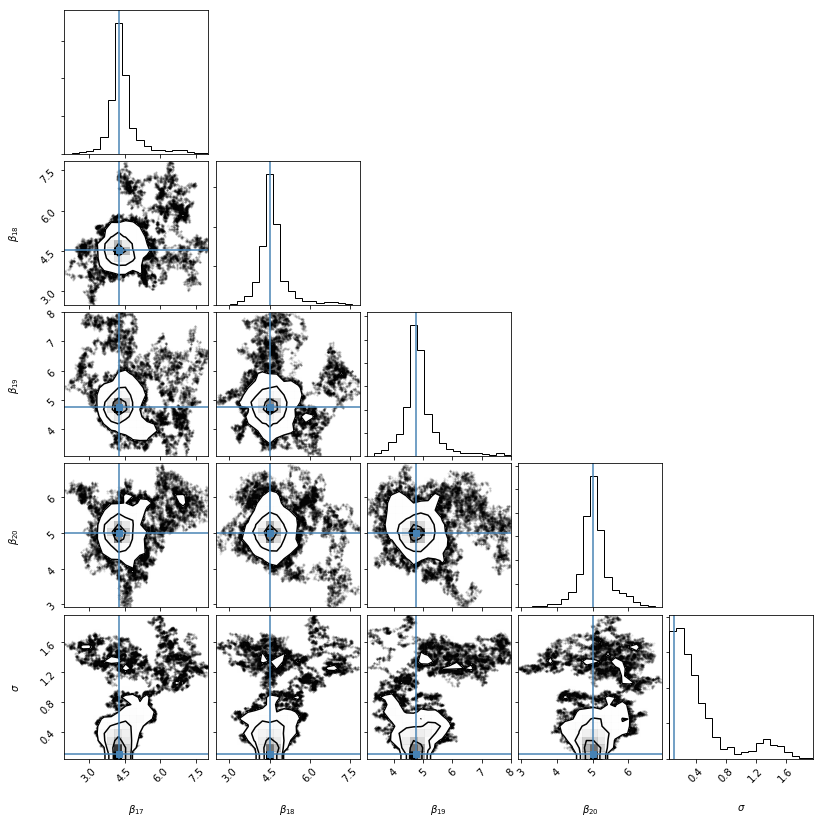

In [11]:
_ = corner.corner(param_samples[:,-5:], truths=params[-5:], labels=param_names[-5:])
plt.savefig("HMC_InferredSigma_11Parameters_200000Samples_Burnin10000.png")